

```
# This is formatted as code
```


# RISEI for 3D medical MRI images

---



Mount the google drive with the data.

In [2]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Install SimpleITK
!pip install SimpleITK

## Get info about our machine.

In [3]:
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   31G   72G  30% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G     0  5.9G   0% /dev/shm
tmpfs           6.4G   20K  6.4G   1% /var/colab
/dev/sda1       114G   32G   83G  29% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           108G   40G   69G  37% /content/gdrive
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp l

Helper method to plot, the middle layer of mri image.

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_itk_image(mr_image, z=None):
  if z is None:
    # display the middle layer
    z = int(mr_image.GetDepth() / 2)
  
  npa_zslice = sitk.GetArrayViewFromImage(mr_image)[z, :, :]
  fig = plt.figure(figsize=(10, 10))

  fig.add_subplot(1, 2, 1)
  plt.imshow(npa_zslice)
  plt.title('default colormap', fontsize=10)
  plt.axis('off')

  fig.add_subplot(1, 2, 2)
  plt.imshow(npa_zslice, cmap=plt.cm.Greys_r);
  plt.title('grey colormap', fontsize=10)
  plt.axis('off')

In [5]:
import os

import SimpleITK as sitk


def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join("/content/gdrive/My Drive/saliencies_and_segmentations_v2", sub_path)

## Get info about the MRI image/s

In [6]:
import SimpleITK as sitk

stats = sitk.StatisticsImageFilter()

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
stats.Execute(image)

max = stats.GetMaximum()
min = stats.GetMinimum()

print(f'min value: {min}, max value: {max}')

min value: -1.0723400115966797, max value: 5.852085590362549


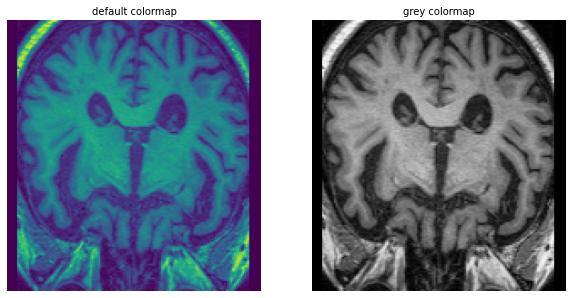

In [7]:
import SimpleITK as sitk

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))

plot_itk_image(image)

## Inpainting (3D)

CPU times: user 1min 34s, sys: 14.4 s, total: 1min 48s
Wall time: 1min 22s


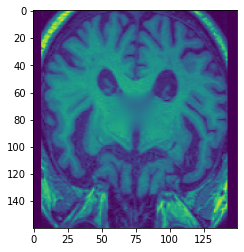

In [8]:
%%time

# create an inpaint image mask

from skimage.restoration import inpaint

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
np_image = sitk.GetArrayViewFromImage(image)

# create a static binary mask
mask = np.zeros(np_image.shape, dtype=np.uint8)
mask[60:90, 60:90, 60:90] = 1
mask[20:40, 40:50, 20:25] = 1

# inpaint an image
image_result = inpaint.inpaint_biharmonic(np_image, mask, multichannel=False)

# show the middle layer
plt.imshow(image_result[80])

## Binary mask generation

In [9]:
import time
import numpy as np

def get_binary_mask():
    # generate a random grid (binary mask)
    grid = np.random.rand(8, 8, 8) < 0.5
    options = {'cell_size': [23, 23, 22], 'input_size': [160, 160, 150] }
    
    # create a static grid (binary mask)
    # grid = np.zeros((8, 8, 8))
    # grid[:, 4:8, 4:8] = 1

    shift_x = 6
    shift_y = 8
    shift_z = 0

    new_grid = np.zeros([184, 184, 176])
    input_size = options['input_size']  
    start = time.time()

    for a in range(0, grid.shape[0]):
      for b in range(0, grid.shape[1]):
        for c in range(0, grid.shape[2]):
          x = a * options['cell_size'][0]
          y = b * options['cell_size'][1]
          z = c * options['cell_size'][2]

          new_grid[x:x + options['cell_size'][0], y:y + options['cell_size'][1], z:z + options['cell_size'][2]] = int(grid[a][b][c])
            
    end = time.time()
    # print(f"gbm: {end - start}")

    return new_grid[shift_x:input_size[0] + shift_x, shift_y:input_size[1] + shift_y, shift_z:input_size[2] + shift_z]


get_binary_mask()

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0.

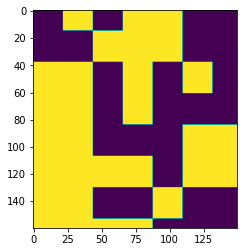

In [10]:
bm = get_binary_mask()

plt.imshow(bm[0])

## Inpainting

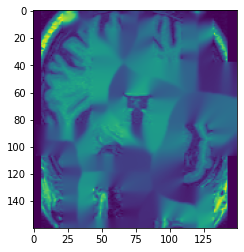

In [12]:
import cv2

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
np_image = sitk.GetArrayViewFromImage(image)

im = cv2.inpaint(
    np_image[80],
    (1 - get_binary_mask()[0]).astype(np.uint8),
    5,
    cv2.INPAINT_NS # cv2.INPAINT_NS, cv2.INPAINT_TELEA
)

plt.imshow(im)

## 2d inpainting (all z-index)

In [16]:
%%time

import cv2

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
np_image = sitk.GetArrayViewFromImage(image)

bm = (1 - get_binary_mask()).astype(np.uint8)
im = np.zeros(np_image.shape)

for z in range(np_image.shape[0]):
  im[z] = cv2.inpaint(
      np_image[z],
      bm[z],
      5,
      cv2.INPAINT_NS
  )

CPU times: user 3.23 s, sys: 40.1 ms, total: 3.27 s
Wall time: 3.3 s


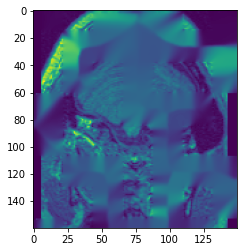

In [14]:
plt.imshow(im[21])

## Blending

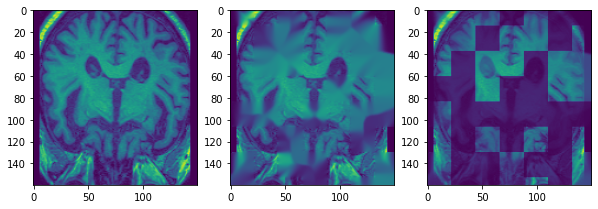

In [17]:
# blend two images

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
np_image = sitk.GetArrayViewFromImage(image)

npm_image = np_image[80]
inpainted = cv2.inpaint(
    npm_image,
    (1 - get_binary_mask()[0]).astype(np.uint8),
    5,
    cv2.INPAINT_NS # cv2.INPAINT_NS, cv2.INPAINT_TELEA
)

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(npm_image)

fig.add_subplot(1, 3, 2)
plt.imshow(inpainted)

alpha = 0.5
blend = alpha * inpainted + (1 - alpha) * npm_image

mask = get_binary_mask()[80]
blend = (blend - blend.min()) * (1 - ((1 - mask) * 0.8))

fig.add_subplot(1, 3, 3)
plt.imshow(blend)

## RISEI

In [1]:
import os
import time
import cv2

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.restoration import inpaint

from multiprocessing import Pool

from tensorflow.keras import preprocessing

from PIL import Image

def generate_mask(params):
    grid = params['grid']
    options = params['options']
    i = params['i']
    image_data = params['image_data']

    shift_x, shift_y, shift_z = __get_random_shift(options)

    # mask has a soft corners
    mask = __get_mask(options, grid, shift_x, shift_y, shift_z)
    # binary mask does not have a soft corners and is used for an inpainting
    binary_mask = __get_binary_mask(options, grid, shift_x, shift_y, shift_z)
    
    inpaint_mask = None
    if options['b1'] > 0:
      inpaint_mask = __get_inpaint_mask(options, image_data, binary_mask)
    
    new_image = __merge(options, image_data, mask, inpaint_mask)

    cache = None
    # when the debug mode is enabled
    # save the generated images to cache
    if options['debug']:
        cache = {
            'grid': grid,
            'mask': mask,
            'binary_mask': binary_mask,
            'inpaint_mask': inpaint_mask,
        }

    return i, new_image, cache

def __merge(options, original_image, mask, inpaint_mask):
    original_image = (original_image - original_image.min())

    # blend original image with inpaint mask if exists
    new_image = original_image

    if inpaint_mask is not None:
      new_image = (1 - options['b1']) * original_image + options['b1'] * inpaint_mask

    # blend original image with inpaint mask with mask
    new_image = new_image * (1 - ((1 - mask) * options['b2']))

    return new_image

def __get_inpaint_mask(options, image_data, binary_mask):
    if options['inpaint'] == '3d':
        return __get_inpaint_mask_3d(options, image_data, binary_mask)
    return __get_inpaint_mask_2d(options, image_data, binary_mask)


def __get_inpaint_mask_3d(options, image_data, binary_mask):
    start = time.time() 

    inverted_binary_mask = 1 - binary_mask.astype(np.uint8)
    inpainted = inpaint.inpaint_biharmonic(image_data, inverted_binary_mask, multichannel=False);
    
    end = time.time()  
    print(f"in: {end - start}")

    return inpained


def __get_inpaint_mask_2d(options, image_data, binary_mask):
    start = time.time() 
    
    inpainted = np.zeros(image_data.shape)
    inverted_binary_mask = (1 - binary_mask).astype(np.uint8)
      
    for z in range(0, image_data.shape[0]):
      inpainted[z] = cv2.inpaint(
          image_data[z],
          inverted_binary_mask[z],
          options['inpaint_radius'],
          options['inpaint_algorithm']
      )

    end = time.time()
    
    # print(f"in: {end - start}")

    return inpainted


def __get_random_shift(options):    
    shift_x = np.random.randint(0, options['over_image_size'][0])
    shift_y = np.random.randint(0, options['over_image_size'][1])
    shift_z = np.random.randint(0, options['over_image_size'][2])

    return shift_x, shift_y, shift_z


def __get_mask(options, grid, shift_x, shift_y, shift_z):
    return resize(grid,
                  options['mask_size'],
                  order=1,
                  mode='reflect',
                  anti_aliasing=False)[shift_y:shift_y + options['input_size'][0], shift_x:shift_x + options['input_size'][1], shift_z:shift_z + options['input_size'][2]]


def __get_binary_mask(options, grid, shift_x, shift_y, shift_z):
    new_grid = np.zeros(options['mask_size'])
    input_size = options['input_size']  
    start = time.time()

    for a in range(0, grid.shape[0]):
      for b in range(0, grid.shape[1]):
        for c in range(0, grid.shape[2]):
          x = a * options['cell_size'][0]
          y = b * options['cell_size'][1]
          z = c * options['cell_size'][2]

          new_grid[x:x + options['cell_size'][0], y:y + options['cell_size'][1], z:z + options['cell_size'][2]] = int(grid[a][b][c])
            
    end = time.time()
    # print(f"gbm: {end - start}")

    return new_grid[shift_x:input_size[0] + shift_x, shift_y:input_size[1] + shift_y, shift_z:input_size[2] + shift_z]


class RISEI():
    def __init__(self, input_size, **kwargs):
        self.options = {
            'input_size': input_size,
            's': kwargs.get('s', 8),  # size of the "grid" - binary mask
            'p1': kwargs.get('p1', 0.5),  # probability of cell being white - transparent
            'b1': kwargs.get('b1', 0.8),  # inpaint mask blend
            'b2': kwargs.get('b2', 0.5),  # black mask blend
            'inpaint': kwargs.get('inpaint', '2d'), # 3d, 2d
            'inpaint_radius': kwargs.get('inpaint_radius', 20),  # inpainting radius
            'inpaint_algorithm': kwargs.get('inpaint_algorithm', cv2.INPAINT_NS), # cv2.INPAINT_TELEA, cv2.INPAINT_NS
            'debug': kwargs.get('debug', False),
            'mask_size': None,
            'cell_size': None,
            'over_image_size': None,
            'processes': kwargs.get('processes', 4),
        }

        self.cache = None

        self.__get_grid_size()

    def generate_masks(self, N, image):
        self.__initialize_cache(N, image)

        grids = self.__get_empty_grids(N)
        images_data = self.__get_empty_images_data(N)

        process_pool = Pool(processes=self.options['processes'])
        params = [{ 'i': i, 'options': self.options, 'grid': grids[i], 'image_data': image } for i in range(0, N)]

        with process_pool as p:
            with tqdm(desc='Generating masks', total=N) as pbar:
                for i, new_image, cache in p.imap_unordered(generate_mask, params):
                    images_data[i, :, :, :] = new_image

                    if cache is not None:
                        self.__save_to_cache(i, new_image, cache)

                    pbar.update()

        return images_data

    def show_from_last_run(self, i, z, figsize=(12, 8), ncols=3, nrows=2):
        original_image = self.show_image_from_last_run(i, z)
        mask = self.show_mask_from_last_run(i, z)
        binary_mask = self.show_binary_mask_from_last_run(i, z)
        inpaint = self.show_inpaint_from_last_run(i, z)
        result = self.show_result_from_last_run(i, z)

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        ax = axes.ravel()

        ax[0].set_title('Original')
        ax[0].imshow(original_image)

        ax[1].set_title('Binary mask')
        ax[1].imshow(binary_mask)

        ax[2].set_title('Mask')
        ax[2].imshow(mask)

        ax[3].set_title('Inpaint')
        ax[3].imshow(inpaint)

        ax[4].set_title('Result')
        ax[4].imshow(result)

        for a in ax:
            a.axis('off')

        fig.tight_layout()
        plt.show()

    def show_mask_from_last_run(self, i, z):
        mask = self.__get_from_cache('masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_binary_mask_from_last_run(self, i, z):
        binary_mask = self.__get_from_cache('binary_masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * binary_mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_image_from_last_run(self, i, z):
        return image[z, :, :]

    def show_inpaint_from_last_run(self, i, z):
        return self.__get_from_cache('inpaint_masks', i)[z, :, :]        

    def show_result_from_last_run(self, i, z):
        return self.__get_from_cache('images_data', i)[z, :, :]

    def __get_from_cache(self, key, i):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')
        if len(self.cache[key]) <= i:
            raise Exception(f'Index {i} does not exist!')
        return self.cache[key][i]

    def __save_to_cache(self, i, image_data, cache):
        self.cache['images_data'][i] = image_data
        self.cache['grids'][i] = cache['grid']
        self.cache['masks'][i] = cache['mask']
        self.cache['binary_masks'][i] = cache['binary_mask']
        self.cache['inpaint_masks'][i] = cache['inpaint_mask']

    def __initialize_cache(self, N, image):
        if self.options['debug']:
            self.cache = {
                'image': image,
                'images_data': np.empty((N, *self.options['input_size'])),
                'grids': np.empty((N, self.options['s'], self.options['s'], self.options['s'])),
                'masks': np.empty((N, *self.options['input_size'])),
                'binary_masks': np.empty((N, *self.options['input_size'])),
                'inpaint_masks': np.empty((N, *self.options['input_size'])),
            }
        else:
            self.cache = None
            
    def __get_empty_grids(self, N):
        grids = np.random.rand(N, self.options['s'], self.options['s'], self.options['s']) < self.options['p1']
        return grids.astype('float32')

    def __get_empty_images_data(self, N):
        return np.empty((N, *self.options['input_size']))
    
    def __get_grid_size(self):
        # the size of one pixel (rectangle)
        cell_size = np.ceil(np.array(self.options['input_size']) / self.options['s'])

        # the additional size for each rectangle
        # since we do a crop from the mask, we
        # need to make a "bigger" mask
        # we calculate how much we need to increase the cell
        # to increase the current size by one additional cell
        over_cell_size = np.ceil((((self.options['s'] + 1) * cell_size) - (self.options['s'] * cell_size)) / self.options['s'])

        # new cell size
        new_cell_size = cell_size + over_cell_size

        # mask size (mask is larger than the image)
        mask_size = (self.options['s'] * new_cell_size).astype(np.uint32)

        # difference in size between original image and mask
        over_image_size = mask_size - self.options['input_size']    

        self.options['mask_size'] = mask_size
        self.options['cell_size'] = new_cell_size.astype(np.uint32)
        self.options['over_image_size'] = over_image_size

### RISEI - one mask

Generating masks: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


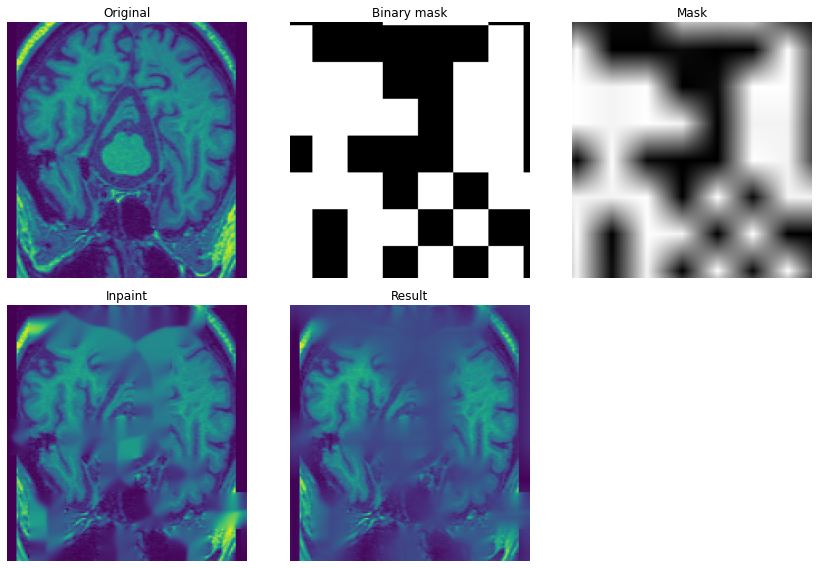

CPU times: user 669 ms, sys: 1.02 s, total: 1.69 s
Wall time: 7.04 s


In [22]:
%%time

raw_image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=0.85, b2=0.9, inpaint="2d", inpaint_radius=5, processes=1, debug=True)

masks = risei.generate_masks(1, image)

risei.show_from_last_run(0, 60)

### RISEI - 100 masks

In [ ]:
# a = []
# while(1):
#     a.append("1")

In [6]:
%%time

raw_image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=0.85, b2=0.9, inpaint="2d", inpaint_radius=5, processes=2, debug=False)

masks = risei.generate_masks(100, image)

Generating masks: 100%|██████████| 100/100 [05:50<00:00,  3.51s/it]

CPU times: user 4.47 s, sys: 4.22 s, total: 8.69 s
Wall time: 5min 51s


## Mask generation (inpaint + binary mask)

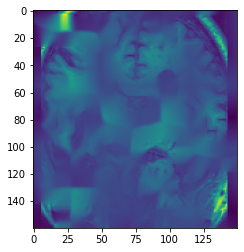

In [7]:
import SimpleITK as sitk
import numpy as np


image_raw = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))

image_data = sitk.GetArrayViewFromImage(image_raw)
grid = np.random.rand(8, 8, 8) < 0.5;

params = {
    'i': 1,
    'grid': grid,
    'image_data': image_data,
    'options': {
        'input_size': (160, 160, 150),
        's': 8,
        'p1': 0.5,
        'b1': 0.95,
        'b2': 1,
        'inpaint': 0.5,
        'inpaint_radius': 5,
        'inpaint_algorithm': 0,
        'debug': True,
        'mask_size': np.array([184, 184, 176], dtype=np.uint32),
        'cell_size': [23, 23, 22],
        'over_image_size': [24, 24, 26],
    }
}

i, new_image, cache = generate_mask(params)

plt.imshow(new_image[80])

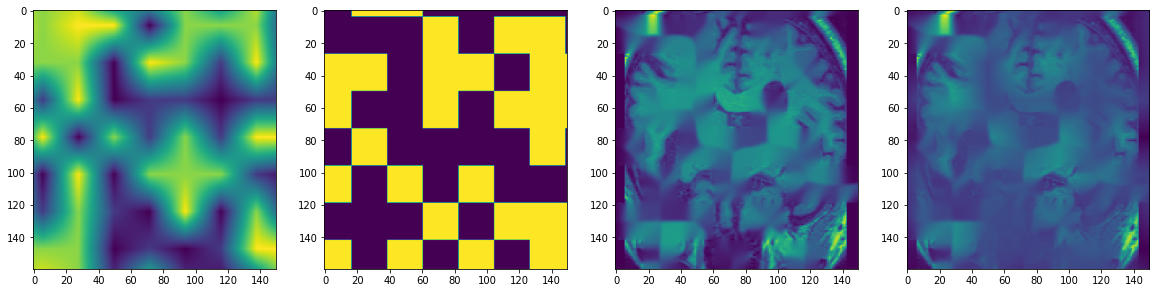

In [8]:
z = 80

fig = plt.figure(figsize=(20, 10))

fig.add_subplot(1, 4, 1)
plt.imshow(cache['mask'][z])

fig.add_subplot(1, 4, 2)
plt.imshow(cache['binary_mask'][z])

fig.add_subplot(1, 4, 3)
plt.imshow(cache['inpaint_mask'][z])

fig.add_subplot(1, 4, 4)
plt.imshow(new_image[z])